In [1]:
# DIRECTORIES

RealImagesDir = "/mnt/DADES2/STELA/data"
RealImagesJsonDir = "/mnt/DADES2/STELA/data/STELA_DATASET.json"

In [10]:
# LIBRARIES
import random
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel,UniPCMultistepScheduler
import torch
import string
import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import NewPal as ft
import json
from diffusers.utils import load_image, make_image_grid
import math

import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt

VERSION=2

NewPal,50



In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # You can change the index if you have more GPUs
    print("CUDA Device Name:", torch.cuda.get_device_name(device))
    print("Memoria Total (MB):", torch.cuda.get_device_properties(0).total_memory // (1024 ** 2))
else:
    print("No CUDA device available")

CUDA Device Name: NVIDIA GeForce RTX 3090
Memoria Total (MB): 24161


In [5]:
# FUNCTIONS

def add_spaces(text):
    return ' '.join(list(text))

def Image2Canny(image, drawing_region, code, font_scale, inside_polygon= True, digit_spacing=5, thresh1=10, thresh2=80, x_initial=None, y_initial=None, method= None):

    # Mask the current ID code
    polygon_points = [(x, y) for label, x, y in drawing_region]
    mask = Image.new('L', image.size, 0) 
    ImageDraw.Draw(mask).polygon(polygon_points, fill=255)

    # Apply Gaussian blur to the imag

    image_rgb = image.convert("RGB")

    blurred_image = image_rgb.filter(ImageFilter.GaussianBlur(radius=5))
    
    final_image = Image.composite(blurred_image, image_rgb, mask)
    image_np = np.array(final_image)

    # Background canny
    gray_with_text = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    canny_background = cv2.Canny(gray_with_text, threshold1=thresh1, threshold2=thresh2)
    # Code canny
    # compute x-initial and y-initial so it is centered in the polygon
    if inside_polygon:

        space = font_scale * - 5 / 0.67

        code_lines = [add_spaces(line) for line in code.split('\n')]
        widths = []
        for line in code_lines:
            widths.append(sum(ft.getCodeWidth(c, font_scale) for c in line) + space * (len(line)))
                
        max_width = max(widths)
    
        if x_initial is None or y_initial is None:
            # Center the code in the polygon
            x_initial = int((drawing_region[0][1] + drawing_region[2][1]) / 2) - int(max_width/2)
            y_initial = int((drawing_region[0][2] + drawing_region[2][2]) / 2) - int(font_scale * 80 / 1.08)

    size = canny_background.shape[:2]
    canny_code, json_data = CannyCode(code, x_initial, y_initial, size, scale=font_scale, digit_spacing=digit_spacing, defect_type=method)

    # Control canny generation
    canny_img = cv2.bitwise_or(canny_background, canny_code)
    canny_img = Image.fromarray(canny_img).convert("RGB")

    return image, Image.fromarray(canny_background).convert("RGB"), Image.fromarray(canny_code).convert("RGB"), canny_img, json_data

def generate_code_lines(num_lines=3, length=10, min_alpha=120):
    # Get list of supported characters from ft.codes
    available_chars = [chr(c) for c in sorted(ft.codes.keys())]

    # Extract alphabets from available_chars (assuming you want A-Z, a-z) and not accents or special characters
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    numbers = [str(i) for i in range(10)]
    alphabets.extend(numbers)

    non_alphabets = [c for c in available_chars if c not in alphabets]

    lines = []
    for _ in range(num_lines):
 
        line_chars = [random.choice(alphabets) for _ in range(length - 1)]
        line_chars.append(random.choice(non_alphabets))

        # Shuffle so alphabets are not always at start
        random.shuffle(line_chars)
        lines.append(''.join(line_chars))

    return '\n'.join(lines)

def save_image(image, image_name, output_dir="/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Paper Figures"):
    """
    Save an image to the specified directory.
    Args:
        image (numpy.ndarray or PIL.Image): The image to save.
        image_name (str): The name of the file to save the image as.
        output_dir (str): The directory where the image will be saved.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the image
    image_path = os.path.join(output_dir, image_name)
    image.save(image_path)
    print(f"Image saved to {image_path}")

def CannyCode(code, x, y, mask_size, scale=1.0, digit_spacing=5, defect_type=None):
    """
    Draws text with soft blur and applies a Canny edge detector.
    
    Parameters:
    - code: str - The text code to render
    - x, y: int - Starting position for the text
    - mask_size: (width, height) - Size of the blank mask
    - scale: float - Text scale (default 1.0)
    - digit_spacing: int - Extra spacing between digits
    """
    def drawTextSoftBlur(string, x, y, ix, iy, scale, color, icolor, digit_spacing=5, canvas_shape=(512, 512)):
        """Draws bold text with soft blur, tracks character positions."""

        h, w = canvas_shape[:2]
        drawn_chars = []  # 🌸 We'll store [char, [x, y]] here

        for i, c in enumerate(string):
            code_width = ft.getCodeWidth(c, scale)
            code_height = ft.getCodeHeight(c, scale) if hasattr(ft, "getCodeHeight") else 50 * scale

            # Check bounds before drawing
            if 0 <= x < w and 0 <= y < h and x + code_width < w and y + code_height < h:
                ft.drawCode(c, x, y, scale, color, alpha=0.8)
                ft.drawCode(c, x+1, y + 1, scale, color, alpha=0.8)

                if defect_type == "deflection":
                    ft.drawCode(c, x+12, y- 8, scale, color, alpha=0.8)


                if defect_type == "beam":
                    ft.drawCode(c, x+2, y, scale, color, alpha=0.8)
                    ft.drawCode(c, x-2, y, scale, color, alpha=0.8)
                    ft.drawCode(c, x+3, y, scale, color, alpha=0.8)
                    ft.drawCode(c, x-3, y, scale, color, alpha=0.8)
                    ft.drawCode(c, x, y+2, scale, color, alpha=0.8)
                    ft.drawCode(c, x, y-2, scale, color, alpha=0.8)

                

                # Save character and bottom-left corner
                if c != " ":
                    drawn_chars.append([c, int(x), int(y)])

            extra_spacing = digit_spacing if c != " " else 0
            x += ix + code_width + extra_spacing
            y += iy

            if icolor is not None:
                color = tuple(np.clip(np.array(color) + np.array(icolor), 0, 255))

        return drawn_chars


        # Prepare mask
    mask = np.zeros(mask_size, dtype=np.uint8)

    # Prepare text lines
    code_lines = [add_spaces(line) for line in code.split('\n')]

    # Drawing setup
    color = (1, 1, 1)       # white 💮
    icolor = (0, 0, 0)      # no inner color change
    space = scale * -5 / 0.67

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    ax.set_position([0, 0, 1, 1])
    ax.imshow(mask, cmap='gray', aspect='auto')
    ax.axis('off')

    cur_y = y
    json_data = {"chars": [], "code": code, "scale": scale}

    for line in code_lines:
        chars = drawTextSoftBlur(line, x, cur_y, space, 0, scale, color, icolor, digit_spacing, canvas_shape=mask_size)
        cur_y += scale * 80 / 1.08
        json_data["chars"].append(chars)

    json_data["chars"] = [item for sublist in json_data["chars"] for item in sublist]

    # Render and convert
    fig.canvas.draw()
    fused_img = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    # Image processing
    fused_img = cv2.cvtColor(fused_img, cv2.COLOR_RGBA2BGR)
    dilated_mask = cv2.dilate(fused_img, np.ones((3, 3), np.uint8), iterations=1)
    canny_result = cv2.Canny(dilated_mask, threshold1=10, threshold2=80)

    return canny_result, json_data

# READ DATA

try:
    with open(RealImagesJsonDir, "r") as f: 
        Annotations = json.load(f)
        i = len(Annotations)
        print("JSON file loaded successfully.")
        print(f"Number of entries: {i}")

except FileNotFoundError:
    print("JSON file not found.")

JSON file loaded successfully.
Number of entries: 1696


In [6]:
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
from diffusers.image_processor import VaeImageProcessor

class SD3CannyImageProcessor(VaeImageProcessor):
    def __init__(self):
        super().__init__(do_normalize=False)
    def preprocess(self, image, **kwargs):
        image = super().preprocess(image, **kwargs)
        image = image * 255 * 0.5 + 0.5
        return image
    def postprocess(self, image, do_denormalize=True, **kwargs):
        do_denormalize = [True] * image.shape[0]
        image = super().postprocess(image, **kwargs, do_denormalize=do_denormalize)
        return image

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

controlnet_path = "/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/ConrolNet Training/output"

controlnet = ControlNetModel.from_pretrained(
    controlnet_path, torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
)

pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


StableDiffusionXLControlNetPipeline {
  "_class_name": "StableDiffusionXLControlNetPipeline",
  "_diffusers_version": "0.34.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

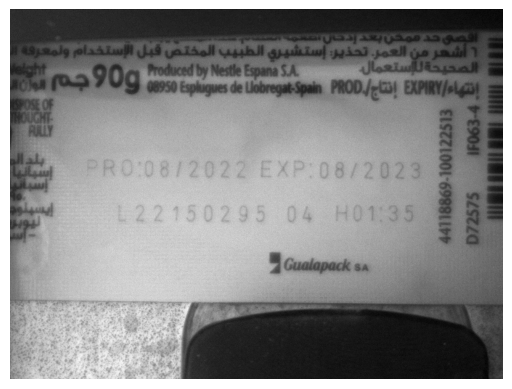

In [ ]:
# Select background image

entry = random.choice(list(Annotations.values()))
file = entry["file"]
drawing_region = entry['reserve']
original_scale = entry['scale']

full_path = os.path.join(RealImagesDir, *file.split('\\'))
original_img = Image.open(full_path)

plt.imshow(original_img, cmap='gray')
plt.axis('off')
plt.show()  

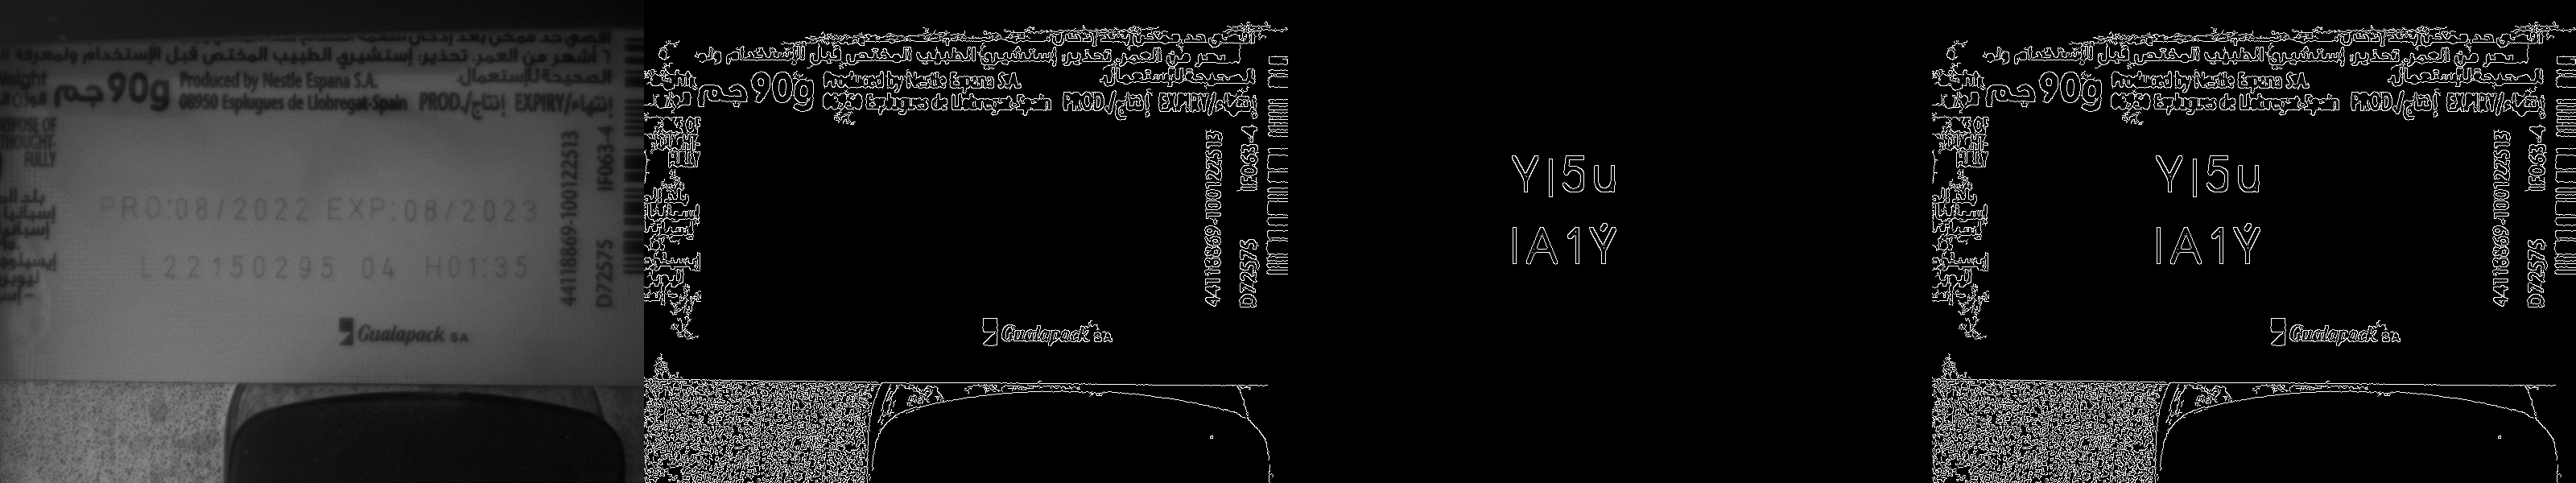

In [39]:
# Generate conditioning image

font_scale = 1.2

thresh1 = 10
thresh2 = 70

digit_spacing = 2
x_initial = 280
y_initial = 250

code = generate_code_lines(num_lines=2, length=4, min_alpha=120) # Random code generation
image, background_canny, background_code, control_img, json_data = Image2Canny(original_img, drawing_region, code, font_scale, thresh1=thresh1, thresh2=thresh2, digit_spacing=digit_spacing, x_initial=x_initial, y_initial=y_initial, method = "valid")

make_image_grid([image, background_canny, background_code, control_img], rows=1, cols=4)


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


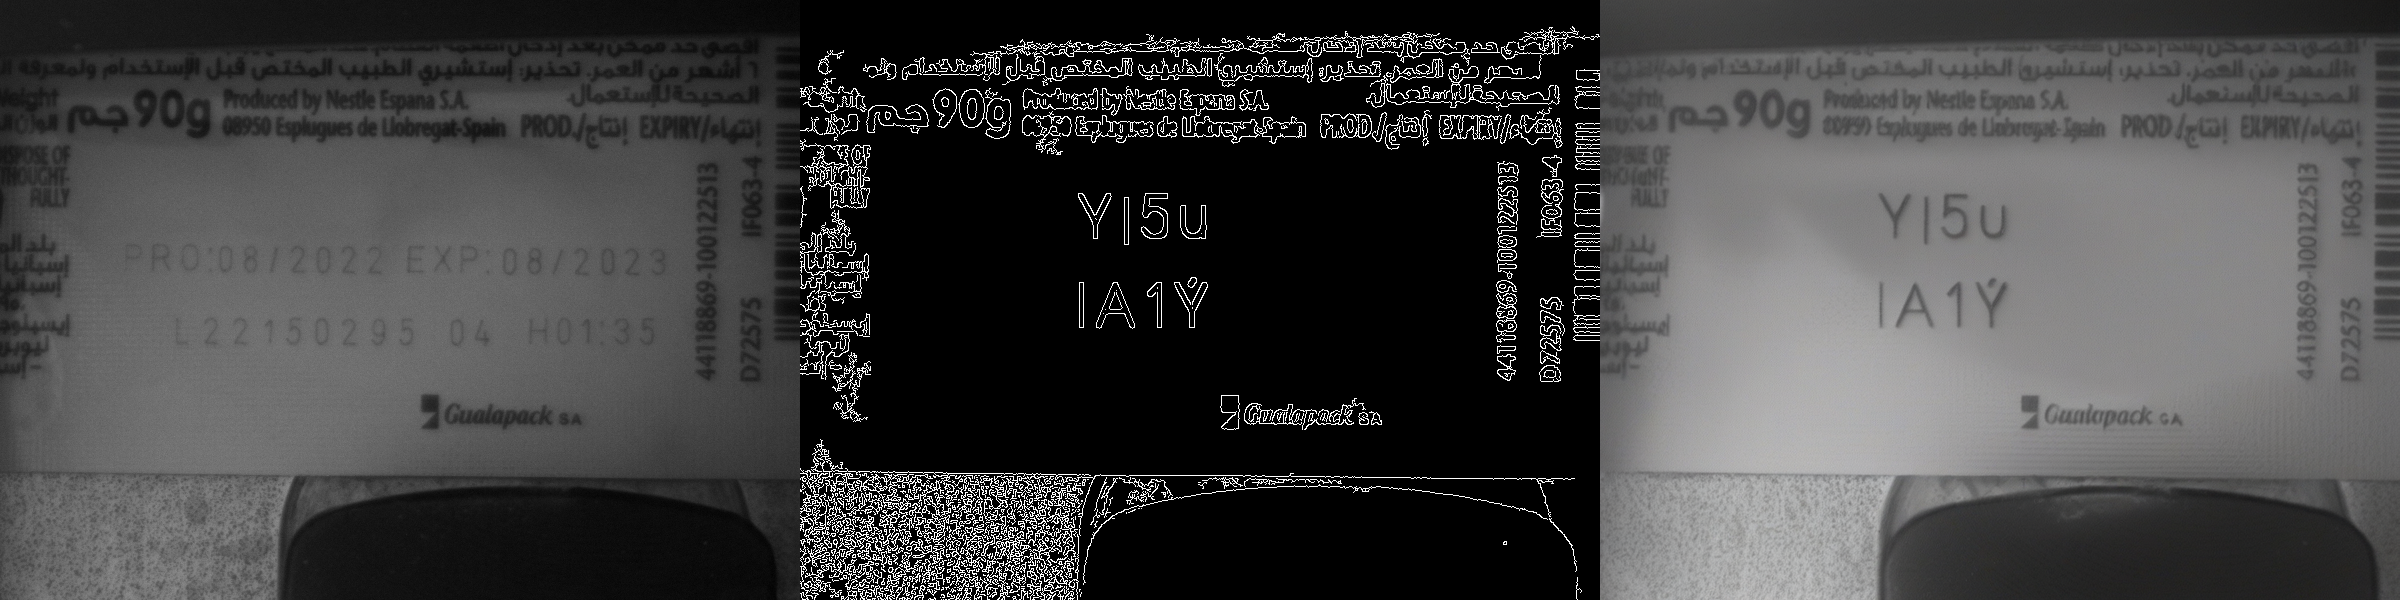

In [40]:
prompt = (

    "Grayscale close-up of a laser-printed label on industrial packaging."
)

num_gen_img = 1
generated_imgs = pipe(
    prompt, 
    image=control_img.convert("RGB").resize((800, 800)), 
    num_inference_steps=20,
    num_images_per_prompt=num_gen_img,
    controlnet_conditioning_scale=1.25,
).images


for i in range(len(generated_imgs)):
    generated_imgs[i] = generated_imgs[i].resize((800, 600), Image.LANCZOS)

control_img = control_img.resize((800, 600), Image.LANCZOS)

make_image_grid([original_img, control_img] + generated_imgs, rows=1, cols=num_gen_img + 2)   